In [12]:
import os
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm

print("Pytorch version : %s"%(torch.__version__))

Pytorch version : 1.7.0


In [9]:
# Convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 10000

# Load training and testing datasets
TrainSet = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size = batchsize, shuffle=True, num_workers=0)
TestSet = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader = torch.utils.data.DataLoader(TestSet, batch_size = batchsize, shuffle=True, num_workers=0)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [25]:
print(TestSet.data.size())

torch.Size([10000, 28, 28])


In [11]:
use_gpu = torch.cuda.is_available()
if(use_gpu):
    device = "cuda"
    print(" GPU detected!")
else:
    device = "cpu"
    print(" GPU not detected")

 GPU detected!


In [121]:
class generator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim):
        super(generator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim),            nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*2),       nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim*4),     nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(hidden_dim*4, out_dim),          nn.ReLU())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return torch.tanh(x)

class discriminator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim):
        super(discriminator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim*4),          nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim*4, hidden_dim*2),     nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim),       nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(hidden_dim, 1),                  nn.ReLU())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return torch.sigmoid(x)

In [128]:
z_dim = 100
mnist_dim = TrainSet.train_data.size(1) * TrainSet.train_data.size(2)

gen_net = generator_net(z_dim, 256, mnist_dim).to(device)
dis_net = discriminator_net(mnist_dim, 256).to(device)

In [129]:
print(gen_net)
print(dis_net)

generator_net(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): ReLU()
  )
)
discriminator_net(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [131]:
def dis_train(inp):
    dis_net.zero_grad()

    num_samples = inp.shape[0]
    # Train discriminator on real data
    x_real = inp.view(-1, mnist_dim).to(device)
    y_real = torch.ones(num_samples, 1).to(device)

    out_real = dis_net(x_real)

    error_real = criterion(out_real, y_real)

    # Train discriminator on generated data
    x_gen  = gen_net(torch.randn(num_samples, z_dim).to(device))
    y_gen  = torch.zeros(num_samples, 1).to(device)

    out_gen = dis_net(x_gen)

    error_gen = criterion(out_gen, y_gen)

    dis_error = error_gen + error_real
    dis_error.backward()

    dis_optim.step()

    return dis_error.item()

In [132]:
def gen_train():
    gen_net.zero_grad()

    x = torch.randn(batchsize, z_dim).to(device)
    y = torch.ones(batchsize, 1).to(device)

    gen_out = gen_net(x)
    dis_out = dis_net(gen_out)

    gen_error = criterion(dis_out, y)

    gen_error.backward()
    gen_optim.step()

    return gen_error.item()

In [143]:
criterion = nn.BCELoss()

gen_optim = optim.Adam(gen_net.parameters(), lr=1e-2)
dis_optim = optim.Adam(dis_net.parameters(), lr=1e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

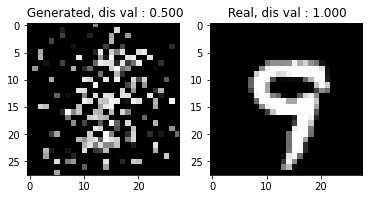

  2%|▏         | 1/50 [00:13<11:04, 13.57s/it] Gen loss :   0.7, Dis loss :   0.7


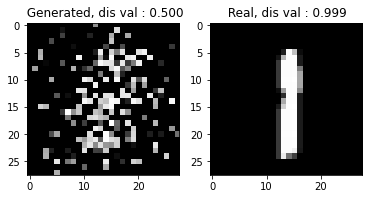

  4%|▍         | 2/50 [00:27<10:51, 13.57s/it] Gen loss :   0.7, Dis loss :   0.7


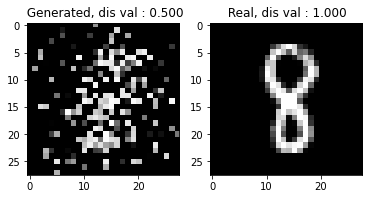

  6%|▌         | 3/50 [00:40<10:38, 13.59s/it] Gen loss :   0.7, Dis loss :   0.7


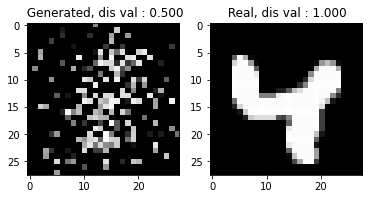

  6%|▌         | 3/50 [00:48<12:41, 16.20s/it]


KeyboardInterrupt: 

In [142]:
iterations = 50
dis_factor = 2      # Number of times discriminator is trained than the generator

num_batch  = TrainSet.data.size()[0] // batchsize

debug = True

for epoch in tqdm(range(iterations)):
    gen_runningloss = 0
    dis_runningloss = 0

    if(debug):
        gen_inp  = torch.randn(1, z_dim).to(device)
        real_img = (list(TrainLoader)[0])[0].view(-1, 28*28)[0].to(device)
        gen_img  = gen_net(gen_inp)

        dis_gout = dis_net(gen_img).cpu()
        dis_rout = dis_net(real_img).cpu()

        plt.subplot(121)
        plt.imshow(gen_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Generated, dis val : %.3f"%(dis_gout))

        plt.subplot(122)
        plt.imshow(real_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Real, dis val : %.3f"%(dis_rout))

        plt.show()

    for i in range(dis_factor):
        for data in TrainLoader:
            inputs, data = data

            dis_loss = dis_train(inputs)

            dis_runningloss += dis_loss

    for i in range(num_batch):
        gen_loss = gen_train()

        gen_runningloss += gen_loss

    gen_runningloss /= num_batch
    dis_runningloss /= (num_batch * dis_factor)
        
    if(debug):
       print(" Gen loss : %5.1f, Dis loss : %5.1f"%(gen_runningloss, dis_runningloss))
     
    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, gen loss %15.1f, disloss %.1f"%(epoch+1, iterations, gen_runningloss, dis_runningloss))

print(" Finished training")

In [120]:
for i in range(10):
    gen_inp = torch.randn(1, z_dim).to(device)
    gen_out = gen_net(gen_inp)

    plt.imshow(gen_out.cpu().view(28, 28).detach().numpy(), cmap='gray')
    plt.title(" Generated image")
    plt.show()

NotImplementedError: 